<a href="https://colab.research.google.com/github/KeerthiPrabu/dl-tools-lab/blob/main/gender_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os

In [ ]:
url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar"

dataset = tf.keras.utils.get_file(
    "wiki_crop", url,
    untar=True, cache_dir='.',
    cache_subdir=''
)
dataset_dir = os.path.join(os.path.dirname(dataset), 'wiki_crop')

811327488/811315200 [==============================] - 34s 0us/step


In [ ]:
import scipy.io
import numpy as np

In [ ]:
mat = scipy.io.loadmat(os.path.join(dataset_dir,'wiki.mat'))
mat

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016',
 '__version__': '1.0',
 'wiki': array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
                 array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
                 array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
                 array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
                 array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
                 array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
               dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
                 array(['Dettmar Cramer'], dtype='<U14'),
                 array(['Marc Okrand'], dtype='<U11'), ...,
                 arr

In [ ]:
gender = mat["wiki"]["gender"][0][0][0].astype(np.float32)
gender.shape

(62328,)

In [ ]:
file_path = np.vectorize(lambda x : os.path.join(dataset_dir,x[0]))(mat["wiki"]["full_path"][0][0][0])

# filtering out nan values
file_path,gender = file_path[~np.isnan(gender)],gender[~np.isnan(gender)]

file_gender_ds = tf.data.Dataset.from_tensor_slices((file_path,gender))

In [ ]:
file_gender_ds.cardinality().numpy()

59685

In [ ]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string,channels=1)
    image = tf.image.resize(image_decoded, [128, 128])
    return image, tf.expand_dims(label,0)

In [ ]:
image_gender_ds = file_gender_ds.map(parse_function).shuffle(seed=2,buffer_size=64).cache()
dataset_size = image_gender_ds.cardinality().numpy()
image_gender_ds

<CacheDataset element_spec=(TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>

In [ ]:
dataset_size

59685

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = image_gender_ds.take(dataset_size*.6).batch(64).prefetch(AUTOTUNE)
val_ds = image_gender_ds.skip(dataset_size*.6).take(dataset_size*.2).batch(64).prefetch(AUTOTUNE)
test_ds = image_gender_ds.skip(dataset_size*.8).take(dataset_size*.2).batch(64).prefetch(AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(5,5),padding="same",activation="relu",input_shape=(128,128,1)),
    tf.keras.layers.MaxPool2D((4,4),strides = 2),
    tf.keras.layers.Conv2D(32,(5,5),padding = "valid",activation="relu"),
    tf.keras.layers.MaxPool2D((4,4),strides = 2),
    tf.keras.layers.Conv2D(64,(5,5),padding = "valid",activation="relu"),
    tf.keras.layers.MaxPool2D((4,4),strides = 2),
    tf.keras.layers.Conv2D(128,(3,3),padding= "valid",activation="relu",),
    tf.keras.layers.MaxPool2D((2,2),strides = 2),
    tf.keras.layers.Conv2D(256,(1,1),padding= "valid",activation="relu",),
    tf.keras.layers.MaxPool2D((2,2),strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(1)       
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 64)       0

In [ ]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=Adam, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=10)

Epoch 1/10
560/560 [==============================] - 59s 83ms/step - loss: 0.5109 - accuracy: 0.7729 - val_loss: 0.4551 - val_accuracy: 0.8140
Epoch 2/10
560/560 [==============================] - 46s 82ms/step - loss: 0.4256 - accuracy: 0.8132 - val_loss: 0.4160 - val_accuracy: 0.7871
Epoch 3/10
560/560 [==============================] - 44s 79ms/step - loss: 0.3741 - accuracy: 0.8475 - val_loss: 0.3623 - val_accuracy: 0.8530
Epoch 4/10
560/560 [==============================] - 45s 80ms/step - loss: 0.3385 - accuracy: 0.8672 - val_loss: 0.3339 - val_accuracy: 0.8733
Epoch 5/10
560/560 [==============================] - 45s 80ms/step - loss: 0.3182 - accuracy: 0.8762 - val_loss: 0.3481 - val_accuracy: 0.8752
Epoch 6/10
560/560 [==============================] - 44s 79ms/step - loss: 0.3068 - accuracy: 0.8813 - val_loss: 0.3243 - val_accuracy: 0.8786
Epoch 7/10
560/560 [==============================] - 44s 79ms/step - loss: 0.3000 - accuracy: 0.8835 - val_loss: 0.3537 - val_accuracy:

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

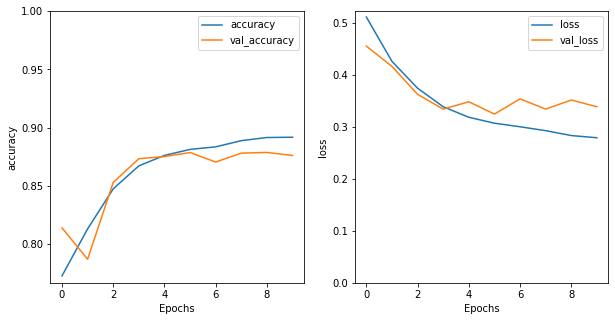

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

187/187 [==============================] - 39s 42ms/step - loss: 0.3424 - accuracy: 0.8740
Loss:  0.3423534333705902
Accuracy:  0.8740051984786987
